1.

In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
X = np.load("moon-all-input.npy")
y = np.load("moon-all-output.npy")

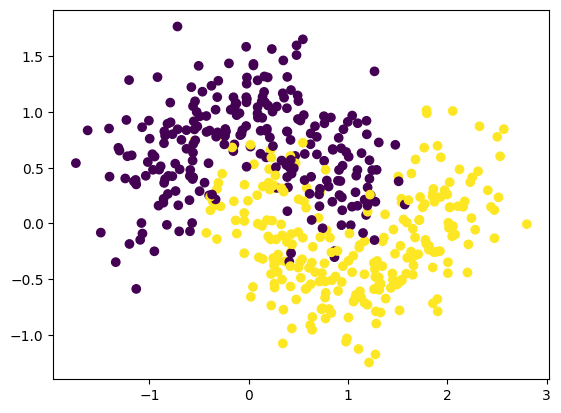

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

2.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

In [8]:
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


LogisticRegression 0.84
RandomForestClassifier 0.88
SVC 0.896
VotingClassifier 0.904


3.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

k = 3000

base_stump = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_clf = AdaBoostClassifier(
    base_stump, n_estimators=k,
    algorithm="SAMME", learning_rate=1, random_state=42
)

ada_clf.fit(X_train, y_train)

classifiers = {}
alphas = []
instance_weights = []
weighted_errors = []
train_accuracies = []
test_accuracies = []

for k, (estimator, alpha) in enumerate(zip(ada_clf.estimators_, ada_clf.estimator_weights_)):

    classifiers[k] = estimator

    alphas.append(alpha)
    instance_weights.append(ada_clf.estimator_errors_[k])

    weighted_error = ada_clf.estimator_errors_[k]
    weighted_errors.append(weighted_error)

    train_pred = ada_clf.staged_predict(X_train)
    train_accuracy = accuracy_score(y_train, next(train_pred))
    train_accuracies.append(train_accuracy)
    
    test_pred = ada_clf.staged_predict(X_test)
    test_accuracy = accuracy_score(y_test, next(test_pred))
    test_accuracies.append(test_accuracy)

c:\Users\jacob\School\CIS4930\adaboost\venv\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


4.

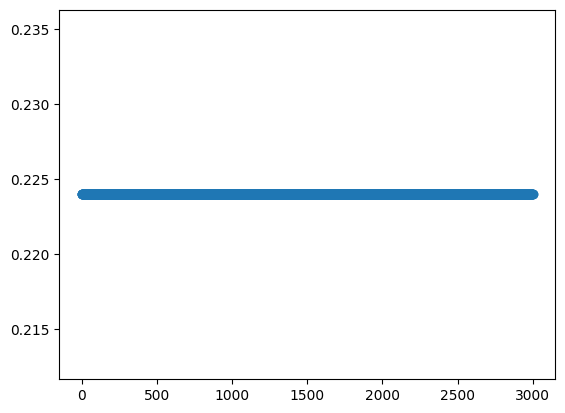

[0.776, 0.776, 0.776, 0.776, 0.776, 0.776, 0.776, 0.776, 0.776, 0.776]


In [13]:
plt.scatter([i for i in range(k+1)], [1-accuracy for accuracy in test_accuracies])
plt.show()

print(test_accuracies[90:100])
